In [11]:
!pip install datapackage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 78.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 379.4 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 307.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 297.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 422.2 kB/s eta 0:00:00:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 361.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 167.8 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 164.7 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 297.9 kB/s eta 0:00:00a 0:00:01
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10745 sha256=2ba95ba4920313

In [23]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from datapackage import Package

%matplotlib inline 

In [32]:
spark = SparkSession.builder.getOrCreate()

In [24]:
package = Package('https://datahub.io/sports-data/english-premier-league/datapackage.json')

# print list of all resources:
print(package.resource_names)

_downloaded = None

# print processed tabular data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        _downloaded = resource.read()
        

        

['validation_report', 'season-1819_csv', 'season-1718_csv', 'season-1617_csv', 'season-1516_csv', 'season-1415_csv', 'season-1314_csv', 'season-1213_csv', 'season-1112_csv', 'season-1011_csv', 'season-0910_csv', 'season-1819_json', 'season-1718_json', 'season-1617_json', 'season-1516_json', 'season-1415_json', 'season-1314_json', 'season-1213_json', 'season-1112_json', 'season-1011_json', 'season-0910_json', 'english-premier-league_zip', 'season-1819', 'season-1718', 'season-1617', 'season-1516', 'season-1415', 'season-1314', 'season-1213', 'season-1112', 'season-1011', 'season-0910']


In [66]:

# print(_downloaded[50])

schema = StructType([
    StructField("Div", StringType(), True),
    StructField("Date", DateType(), True),
    StructField("HomeTeam", StringType(), True),
    StructField("AwayTeam", StringType(), True),
    StructField("FTHG", IntegerType(), True),
    StructField("FTAG", IntegerType(), True),
    StructField("FTR", StringType(), True),
    StructField("HTHG", IntegerType(), True),
    StructField("HTAG", IntegerType(), True),
    StructField("HTR", StringType(), True),
    StructField("Referee", StringType(), True),
    StructField("HS", IntegerType(), True),
    StructField("AS", IntegerType(), True),
    StructField("HST", IntegerType(), True),
    StructField("AST", IntegerType(), True),
    StructField("HF", IntegerType(), True),
    StructField("AF", IntegerType(), True),
    StructField("HC", IntegerType(), True),
    StructField("AC", IntegerType(), True),
    StructField("HY", IntegerType(), True),
    StructField("AY", IntegerType(), True),
    StructField("HR", IntegerType(), True),
    StructField("AR", IntegerType(), True),
    StructField("B365H", DecimalType(), True),
    StructField("B365D", DecimalType(), True),
    StructField("B365A", DecimalType(), True),
    StructField("BWH", DecimalType(), True),
    StructField("BWD", DecimalType(), True),
    StructField("BWA", DecimalType(), True),
    StructField("IWH", DecimalType(), True),
    StructField("IWD", DecimalType(), True),
    
] + [StructField(f'{i}', StringType(), False) for i in range(40)])

# print(schema)

df = spark.createDataFrame(_downloaded, schema)
df.show()


+---+----------+-----------+----------+----+----+---+----+----+---+-------------+---+---+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+-----+-----+---+----+----+----+----+---+---+----+----+-----+-----+
|Div|      Date|   HomeTeam|  AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|      Referee| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|B365H|B365D|B365A|BWH|BWD|BWA|IWH|IWD|   0|   1|   2|   3|   4|   5|   6|   7|   8|   9|  10|  11|  12|  13|  14|  15|  16|  17|  18|  19|  20|  21| 22|  23|  24|  25|  26|   27|   28| 29|  30|  31|  32|  33| 34| 35|  36|  37|   38|   39|
+---+----------+-----------+----------+----+----+---+----+----+---+-------------+---+---+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--

In [67]:
df.describe()

DataFrame[summary: string, Div: string, HomeTeam: string, AwayTeam: string, FTHG: string, FTAG: string, FTR: string, HTHG: string, HTAG: string, HTR: string, Referee: string, HS: string, AS: string, HST: string, AST: string, HF: string, AF: string, HC: string, AC: string, HY: string, AY: string, HR: string, AR: string, B365H: string, B365D: string, B365A: string, BWH: string, BWD: string, BWA: string, IWH: string, IWD: string, 0: string, 1: string, 2: string, 3: string, 4: string, 5: string, 6: string, 7: string, 8: string, 9: string, 10: string, 11: string, 12: string, 13: string, 14: string, 15: string, 16: string, 17: string, 18: string, 19: string, 20: string, 21: string, 22: string, 23: string, 24: string, 25: string, 26: string, 27: string, 28: string, 29: string, 30: string, 31: string, 32: string, 33: string, 34: string, 35: string, 36: string, 37: string, 38: string, 39: string]

In [68]:
# partition by Home team
df_home = df.repartition('HomeTeam')

In [69]:
df_home.show()
df_home.count()

+---+----------+----------+----------+----+----+---+----+----+---+-------------+---+---+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+-----+-----+---+----+----+----+----+---+---+----+----+-----+-----+
|Div|      Date|  HomeTeam|  AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|      Referee| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|B365H|B365D|B365A|BWH|BWD|BWA|IWH|IWD|   0|   1|   2|   3|   4|   5|   6|   7|   8|   9|  10|  11|  12|  13|  14|  15|  16|  17|  18|  19|  20|  21| 22|  23|  24|  25|  26|   27|   28| 29|  30|  31|  32|  33| 34| 35|  36|  37|   38|   39|
+---+----------+----------+----------+----+----+---+----+----+---+-------------+---+---+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

380

In [70]:
df_home.createOrReplaceTempView("EPL")

In [71]:
tt_df = spark.sql("""
WITH new_table AS (
    SELECT *, CASE WHEN FTR = "H" THEN 1 WHEN FTR = "A" THEN 2 ELSE 3 END AS label
    FROM EPL
  )
  SELECT *
  FROM new_table
""")
tt_df.show(5)

+---+----------+---------+----------+----+----+---+----+----+---+----------+---+---+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+---+---+---+---+---+----+----+---+----+----+---+----+----+----+---+----+---+---+----+----+---+----+----+----+----+----+---+---+----+----+----+----+-----+----+---+----+----+----+----+---+---+----+----+----+----+-----+
|Div|      Date| HomeTeam|  AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|   Referee| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|B365H|B365D|B365A|BWH|BWD|BWA|IWH|IWD|   0|   1|  2|   3|   4|  5|   6|   7|   8|  9|  10| 11| 12|  13|  14| 15|  16|  17|  18|  19|  20| 21| 22|  23|  24|  25|  26|   27|  28| 29|  30|  31|  32|  33| 34| 35|  36|  37|  38|  39|label|
+---+----------+---------+----------+----+----+---+----+----+---+----------+---+---+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+---+---+---+---+---+----+----+---+----+----+---+----+----+----+---+----+---+---+----+----+---+----+----+----+----+----+---+---+----+----+---

In [72]:

# convert to pandas dataframe
df_pandas = tt_df.toPandas()


# one hot encode the HomeTeam and AwayTeam
df_pandas['HomeTeam'] = df_pandas['HomeTeam'].apply(hash)
df_pandas['Div'] = df_pandas['Div'].apply(hash)
df_pandas['Referee'] = df_pandas['Referee'].apply(hash)

df_pandas.head()
df_pandas.tail()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,31,32,33,34,35,36,37,38,39,label
375,5161056934263516172,2010-04-25,-2162237610001898879,Fulham,2,1,H,0,1,A,...,1.89,1.96,1.85,17,0,1.13,1.09,8,6.51,1
376,5161056934263516172,2010-05-09,-2162237610001898879,Portsmouth,1,0,H,0,0,D,...,1.56,2.4,2.3,15,0,1.1,1.06,10,7.72,1
377,5161056934263516172,2010-04-14,7427125512664846001,Portsmouth,0,0,D,0,0,D,...,1.95,1.91,1.8,14,0,1.2,1.17,5,4.44,3
378,5161056934263516172,2010-04-18,7427125512664846001,Arsenal,3,2,H,0,1,A,...,1.76,2.19,2,14,0,5,4.6,1.22,1.17,1
379,5161056934263516172,2010-05-03,7427125512664846001,Hull,2,2,D,1,1,D,...,1.94,1.89,1.82,19,0,1.36,1.33,3.4,3.11,3


In [73]:

X = df_pandas[['HomeTeam', 'FTHG','FTAG','HTHG','HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']]
y = df_pandas['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
lm = LogisticRegression(max_iter=100000)
lm.fit(X_train,y_train)



LogisticRegression(max_iter=100000)

[ 8.29165706e-38 -4.43494320e-38 -3.85671386e-38]


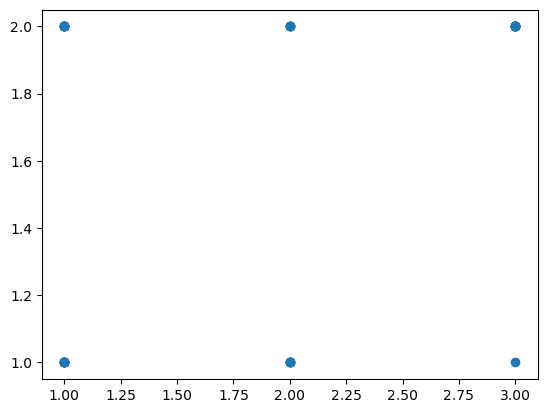

In [74]:
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)

print(lm.intercept_)
# coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
# coeff_df

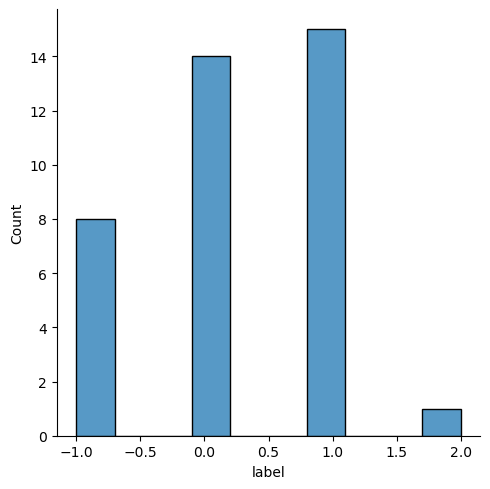

In [64]:
sns.displot((y_test-predictions),bins=10);

In [65]:
# create a new row to predict
new_row = [[-3703561339968655798, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1]]
new_row_df = pd.DataFrame(new_row, columns=['HomeTeam','FTHG','FTAG','HTHG','HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR'])

new_row_df.head()

predictions = lm.predict(new_row_df)
print(predictions)



[1]
